In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import torch
import torch.nn as nn
import cebra_v2 as cebra2
from collections import defaultdict
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA,FastICA
from torch.utils.data.sampler import BatchSampler
import package
import pandas as pd
import matplotlib.animation as animation
import tembedding
import scipy as sc
from skimage.metrics import structural_similarity as ssim
from sklearn.cluster import KMeans,OPTICS
import math
from joblib import Memory,Parallel,delayed,parallel_backend
import time
from multiprocessing import Lock, Process, Queue
import multiprocessing
import queue 
import os
import networkx as nx
from scipy.spatial.transform import Rotation as R
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import axes3d

In [15]:
import importlib
importlib.reload(package.preprocessing)
importlib.reload(cebra2.criterion)
importlib.reload(cebra2.dataset)

<module 'cebra_v2.dataset' from '/volatile/aurelien_stumpf_mascles/project/code/cebra_v2/dataset.py'>

## Utilitaires

In [2]:
def single_session_solver(data_loader, **kwargs):
    """Train a single session CEBRA model."""
    norm = True
    if kwargs['distance'] == 'euclidean':
        norm = False
    model = kwargs["model"]

    if kwargs['distance'] == 'euclidean':
        criterion = cebra2.criterion.EuclideanInfoNCE(temperature=kwargs['temperature'],beta = kwargs['beta'])
    elif kwargs['distance'] == 'cosine':        
        criterion = cebra2.criterion.CosineInfoNCE(temperature=kwargs['temperature'],beta = kwargs['beta'])

    optimizer = torch.optim.Adam(model.parameters(), lr=kwargs['learning_rate'])

    return cebra2.solver.SingleSessionSolver(model=model,
                                            criterion=criterion,
                                            optimizer=optimizer)

@torch.no_grad()
def get_emissions(model, dataset):
    if torch.cuda.is_available():
        device = "cuda"
    else:
        device = "cpu"
    model.to(device)
    return model(dataset).cpu().numpy()

def _compute_emissions_single(solver, dataset):
    return get_emissions(solver.model, dataset)

## Synthetic data

In [3]:
dfc = np.zeros((6,100,50))
meta = np.concatenate([np.ones((1,100))*i for i in range(6)],axis = 0)

In [4]:
state_vector = np.ones(50)
list_factor = np.linspace(1,1.1,100)

In [91]:
def create_session(dfc,state_vector,i):
    list_factor = np.linspace(1,1.01,dfc.shape[1])
    dfc[i,:] = np.array([list_factor[k] * state_vector for k in range(len(list_factor))])

def generate_dataset(dfc):
    list_factor = np.linspace(1,3,dfc.shape[1])
    for i in range(dfc.shape[0]):
        state_vector = np.random.normal(loc = 0, scale = 10, size = dfc.shape[2])
        dfc[i,:] = np.array([list_factor[k] * state_vector for k in range(len(list_factor))])

def generate_dataset2(dfc):
    return np.random.uniform(low = -10, high = 10, size = dfc.shape)

def generate_dataset3(dfc):
    for i in range(dfc.shape[0]):
        dfc[i,:] =  np.random.normal(loc = 5*i, scale = 1, size = (dfc.shape[1],dfc.shape[2]))


In [92]:
generate_dataset3(dfc)

In [163]:
dfc[5,1,:]

array([4.89616109, 5.06234857, 4.99937906, 5.0403824 , 4.90147854,
       5.03912567, 5.07513253, 5.01157599, 4.99655668, 5.03708574,
       5.01159918, 4.85255666, 4.99911956, 4.88088355, 5.00472157,
       4.90682743, 4.99397549, 5.39201932, 4.88725122, 4.69731518,
       5.01143405, 4.95286126, 4.78870117, 5.18594937, 4.88662978,
       5.01681367, 4.97737153, 4.90585396, 4.96063498, 4.97683753,
       4.95848852, 5.02840888, 4.88686495, 5.02352197, 5.1103689 ,
       5.20792466, 5.10504222, 4.8669555 , 4.96998723, 4.86800423,
       4.76123916, 5.02589512, 4.96438651, 5.0023947 , 4.7811567 ,
       4.96079667, 4.99419858, 4.93974066, 4.91363019, 4.90003467])

## Cebra

In [155]:
#We define the architecture of the model we will use

num_output = 3
normalize = True
num_neurons = 50

model = cebra2.model.Model(
    nn.Linear(
        num_neurons,
        100
    ),
    nn.GELU(),
    nn.Linear(
        100,
        3
    ),
    num_input=num_neurons,
    num_output=num_output,
    normalize = True
        )

In [156]:
fc_train_vector = dfc
discrete = meta

In [157]:
fc_dataset = cebra2.dataset.SimpleMultiSessionDataset(fc_train_vector) #,discrete = discrete)
fc_loader = cebra2.dataset.MultiSessionLoader(fc_dataset, num_steps = 1000, batch_size = 3000, time_delta = 2)

In [158]:
cebra_fc = single_session_solver(data_loader = fc_loader, model_architecture = 'offset1-model', 
                 distance = 'cosine', num_hidden_units = 128, output_dimension = 128,
                verbose = True, temperature = 1, beta = 1,learning_rate = 3e-4, model = model)

In [159]:
cebra_fc.fit(fc_loader)

Epoch 0
Train loss 7.8180, Train accuracy 0.00%
Epoch 100
Train loss 7.1712, Train accuracy 0.00%
Epoch 200
Train loss 7.1722, Train accuracy 0.00%
Epoch 300
Train loss 7.1697, Train accuracy 0.00%
Epoch 400
Train loss 7.1690, Train accuracy 0.00%
Epoch 500
Train loss 7.1684, Train accuracy 0.00%
Epoch 600
Train loss 7.1707, Train accuracy 0.00%
Epoch 700
Train loss 7.1677, Train accuracy 0.00%
Epoch 800
Train loss 7.1712, Train accuracy 0.00%
Epoch 900
Train loss 7.1733, Train accuracy 0.00%


(-1.0980946630239488,
 1.0986962527036668,
 -1.099107825756073,
 1.0936758160591125)

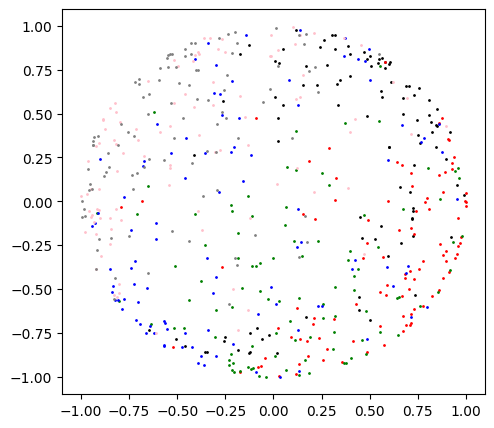

In [154]:
fig = plt.figure(figsize = (12,5))

ax1 = plt.subplot(121)
colors = ["black",'red','green','blue','pink','grey']
for i in range(6):
    data = torch.from_numpy(dfc[i,:]).type(torch.float32)
    fc_emb = _compute_emissions_single(cebra_fc, data)
    ax1.scatter(fc_emb[:,2], fc_emb[:,0], c = colors[int(meta[i,0])], s=1)
#ax1.xticks() 
ax1.axis('on')

(-3.7011005531448546,
 28.980088508523682,
 -4.910444488123974,
 28.118389883589394)

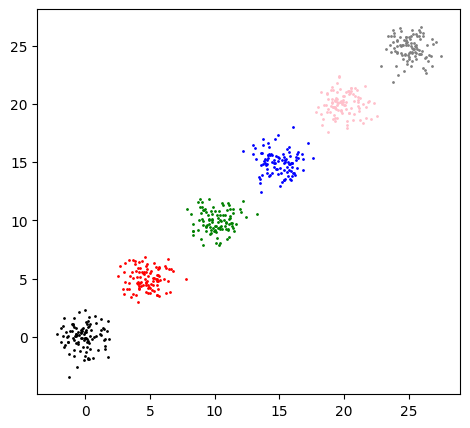

In [130]:
fig = plt.figure(figsize = (12,5))

ax1 = plt.subplot(121)
colors = ["black",'red','green','blue','pink','grey']
for i in range(6):
    ax1.scatter(dfc[i,:,0], dfc[i,:,2], c = colors[int(meta[i,0])], s=1)
#ax1.xticks() 
ax1.axis('on')

In [47]:
fc_emb[:,0]

array([0.85154647, 0.84271604, 0.8054037 , 0.82855004, 0.8131946 ,
       0.7415217 , 0.7432062 , 0.8608511 , 0.8469128 , 0.64217544,
       0.8305512 , 0.82320195, 0.8491223 , 0.79578763, 0.6182777 ,
       0.8175461 , 0.8504333 , 0.80230516, 0.8471003 , 0.82638043,
       0.8019343 , 0.8563623 , 0.79516065, 0.8630579 , 0.8327116 ,
       0.82610893, 0.8330532 , 0.80367434, 0.81344324, 0.8560402 ,
       0.8664488 , 0.82001746, 0.8369263 , 0.8626054 , 0.83434916,
       0.7963342 , 0.8346572 , 0.84812737, 0.83650535, 0.86135453,
       0.835256  , 0.8555301 , 0.8232088 , 0.84169006, 0.83165634,
       0.7664996 , 0.67862934, 0.8362539 , 0.83639157, 0.83652824,
       0.7975961 , 0.92984766, 0.8660097 , 0.831456  , 0.8147686 ,
       0.8151435 , 0.8078452 , 0.83588475, 0.8001504 , 0.8334385 ,
       0.87690324, 0.8330698 , 0.8176767 , 0.8291991 , 0.8555954 ,
       0.80897653, 0.8212079 , 0.85831255, 0.823974  , 0.83280444,
       0.849166  , 0.8330515 , 0.84164   , 0.83329475, 0.83962